# Building Nonlinear Core Correction from PStudio AE Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dftpy.field import DirectField
from dftpy.formats import io
from dftpy.optimization import Optimization
from dftpy.ions import Ions
from dftpy.grid import DirectGrid
from dftpy.math_utils import ecut2nr
from ase import Atoms
from dftpy.math_utils import ecut2nr
from dftpy.constants import Units

## Read Pseudo created with Notebook NLCC_AE_strength.ipynb

In [2]:
from dftpy.functional import LocalPseudo, Functional, TotalFunctional

In [3]:
path_ngbrv = './'
PP_list_ngbrv_ag = {'Ag': path_ngbrv + '/Ag_AE_1_gbrv.psp8'}

In [4]:
ions_ag, rho_target_ag, _ = io.read_all('./rho_Ag_gbrv.xsf')
grid = rho_target_ag.grid

path_gbrv = '/projectsn/mp1009_1/Valeria/NLPP/PP/'
PP_list_gbrv_ag = {'Ag': path_gbrv+'ag_lda_v1.4.uspp.F.UPF'}

nr = ecut2nr(ecut=600, lattice=ions_ag.cell)
grid = DirectGrid(lattice=ions_ag.cell, nr=nr)

pseudo_gbrv_ag = LocalPseudo(grid = grid, ions=ions_ag, PP_list=PP_list_gbrv_ag)
pseudo_gbrv_ag.local_PP()
v_gbrv_ag = pseudo_gbrv_ag.readpp.pp['Ag'].v

pseudo_ngbrv_ag = LocalPseudo(grid = grid, ions=ions_ag, PP_list=PP_list_ngbrv_ag)
pseudo_ngbrv_ag.local_PP()
v_ngbrv_ag = pseudo_ngbrv_ag.readpp.pp['Ag'].v

setting key: Ag -> /projectsn/mp1009_1/Valeria/NLPP/PP/ag_lda_v1.4.uspp.F.UPF
setting key: Ag -> .//Ag_AE_1_gbrv.psp8


In [5]:
core_density_gbrv = pseudo_gbrv_ag.readpp.pp['Ag'].core_density
v_gbrv = pseudo_gbrv_ag.readpp.pp['Ag'].v
r_gbrv = pseudo_gbrv_ag.readpp.pp['Ag'].r
r_core = pseudo_gbrv_ag.readpp.pp['Ag'].core_density_grid

In [6]:
pseudo_ngbrv_ag = LocalPseudo(grid = grid, ions=ions_ag, PP_list=PP_list_ngbrv_ag)
pseudo_ngbrv_ag.local_PP()
v = pseudo_ngbrv_ag.vlines_core
core_density = pseudo_ngbrv_ag.core_density
v_ngbrv_ag = pseudo_ngbrv_ag.readpp.pp['Ag'].v
core_density_ngbrv = pseudo_ngbrv_ag.readpp.pp['Ag'].core_density
r_ngbrv = pseudo_ngbrv_ag.readpp.pp['Ag'].r
r_core = pseudo_ngbrv_ag.readpp.pp['Ag'].core_density_grid

setting key: Ag -> .//Ag_AE_1_gbrv.psp8
Warning 0.0019244498071592695


(0.0, 4.0)

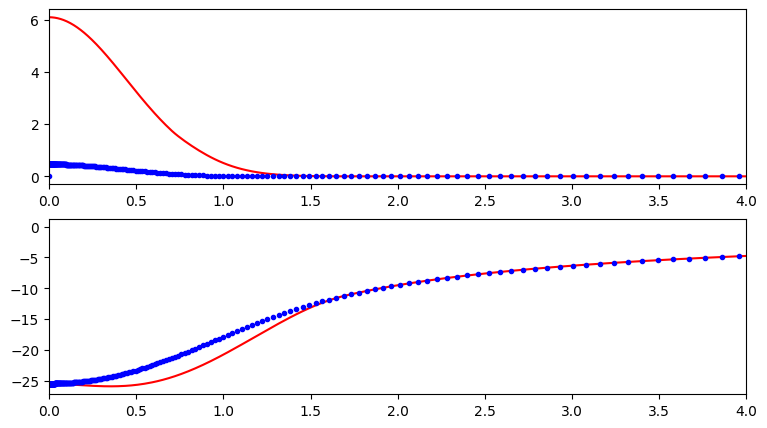

In [7]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(9,5))
axs[0].plot(r_ngbrv, core_density_ngbrv.ravel(), 'r')
axs[0].plot(r_gbrv, core_density_gbrv.ravel(), 'b.')

axs[1].plot(r_ngbrv, (v_ngbrv_ag).ravel(), 'r')
axs[1].plot(r_gbrv, v_gbrv_ag.ravel(), 'b.')
axs[0].set_xlim(0.0,4)
axs[1].set_xlim(0.0,4)

In [8]:
core_density_gbrv = pseudo_gbrv_ag.core_density
core_density_nlcc = pseudo_ngbrv_ag.core_density

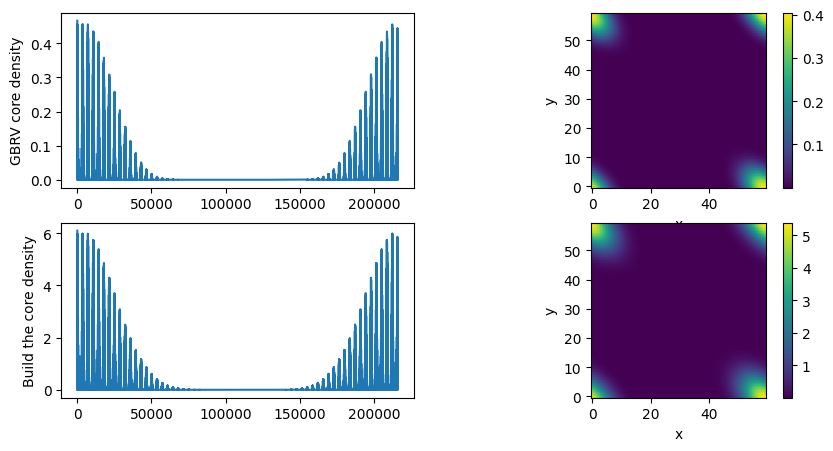

In [9]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,5))
axs[0,0].plot(core_density_gbrv.ravel())

# z_slice = core_density_gbrv.shape[2] // 2
z_slice = 3
im1 = axs[0,1].imshow(core_density_gbrv[:, :, z_slice], origin='lower', cmap='viridis')
# axs[1].colorbar(label="ρ_core")
fig.colorbar(im1, ax=axs[0,1], orientation='vertical')

# axs[0,1].set_title("Midplane Slice of NLCC Field (z = center)")
axs[0,1].set_xlabel("x")
axs[0,1].set_ylabel("y")
axs[0,0].set_ylabel("GBRV core density")
axs[1,0].plot(core_density_nlcc.ravel())
# z_slice = core_density_nlcc.shape[2] // 2
im2=axs[1,1].imshow(core_density_nlcc[:, :, z_slice], origin='lower', cmap='viridis')
fig.colorbar(im2, ax=axs[1,1], orientation='vertical')

# axs[1].colorbar(label="ρ_core")
# axs[1,1].set_title("Midplane Slice of NLCC Field (z = center)")
axs[1,1].set_xlabel("x")
axs[1,1].set_ylabel("y")
axs[1,0].set_ylabel("Build the core density")
plt.show()

## Analysis in reciprocal space 

In [10]:
from dftpy.field import ReciprocalField, DirectField

In [11]:
grid = core_density_nlcc.grid
reciprocal_grid = grid.get_reciprocal()
g = reciprocal_grid.g
rhog = core_density_nlcc.fft()
new_rhog = ReciprocalField(grid=grid, griddata_3d=rhog[:])

In [12]:
new_rhor = new_rhog.ifft()

/projectsn/mp1009_1/Valeria/pyenv/lpps/lib/python3.10/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/projectsn/mp1009_1/Valeria/pyenv/lpps/lib/python3.10/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


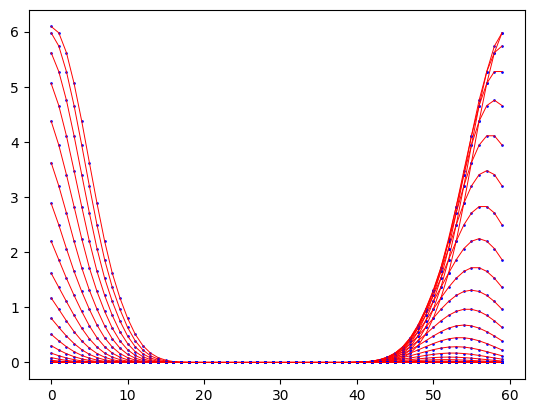

In [13]:
for i in np.arange(0,len(g[0][0])-18):
    plt.plot(core_density_nlcc[0,i,:].ravel(), 'b.', markersize=1.9)
    plt.plot(new_rhor[0,i,:].ravel(), 'r', lw=0.7)

In [14]:
def get_energy(KE, ions, PSEUDO):
    rho_ini = DirectField(grid=grid)
    rho_ini[:] = ions.get_ncharges()/ions.cell.volume
    evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
    opt = Optimization(EnergyEvaluator=evaluator, optimization_options = opt_options,
                       optimization_method = 'CG')
    rho = opt.optimize_rho(guess_rho=rho_ini)
    forces = evaluator.get_forces(rho=rho)
    forces_ewald = evaluator.ewald.forces
    v = KE(rho).potential
    return evaluator.Energy(rho=rho, ions=ions), rho, forces, evaluator, forces_ewald

In [15]:
HARTREE = Functional(type='HARTREE')

In [16]:
from ase import Atoms
E_ngbrv_f = []
F_ngbrv_f = []
F_ngbrv_f_ke = []
F_ngbrv_f_xc = []
F_ngbrv_f_pp = []
F_ngbrv_f_ew = []
F_num = []
V = []

opt_options = {'econv' : 1e-6}
alats = [1.15, 1.2, 1.4, 1.6]#, 1.8, 2.0, 2.5, 3.0, 3.5, 4.0]#, 0.5, 0.7, 0.9, 1.0, 1.2, 1.4]
L = 10
for alat in alats:
    atoms = Atoms('Ag2', positions=[[L/2, L/2, L/2], [alat+L/2, L/2, L/2]])
    atoms.set_cell([L, L, L])
    ions = Ions.from_ase(atoms)
    grid = DirectGrid(lattice=ions.cell, ecut=40)
    print(grid.spacings[0], grid.nr)
    PSEUDO_nGBRV = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list_ngbrv_ag)
    core = PSEUDO_nGBRV.core_density
    v_lines = PSEUDO_nGBRV.vlines_core['Ag']
    XC = Functional(type='XC',name='LDA', core_density=core, pseudo=PSEUDO_nGBRV, libxc=False)
    KE = Functional(type='KEDF', name='TFvW', y=0.2, core_density=core, pseudo=PSEUDO_nGBRV)
    ene_ngbrv, rho, forces, evaluator , forces_ewald= get_energy(KE, ions, PSEUDO_nGBRV)
    forces_ke = KE.forces(rho)#calc_force_cc(potential=KE(core).potential, rhod=v_lines, ions=ions)
    forces_xc = XC.forces(rho)#(potential=XC(core).potential, rhod=v_lines, ions=ions)
    forces_pp = PSEUDO_nGBRV.forces(rho)#(potential=PSEUDO_nGBRV(core).potential, rhod=v_lines, ions=ions)
    # forces_num = compute_numerical_forces(ions, evaluator)
    # F_num.append(forces_num)
    F_ngbrv_f.append(forces)
    F_ngbrv_f_ke.append(forces_ke)
    F_ngbrv_f_pp.append(forces_pp)
    F_ngbrv_f_xc.append(forces_xc)
    F_ngbrv_f_ew.append(forces_ewald)
    E_ngbrv_f.append(ene_ngbrv)

0.34994928256239416 [54 54 54]
setting key: Ag -> .//Ag_AE_1_gbrv.psp8
Warning 0.04209845515380311
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       1.223234532187E+02      1.223235E+02    1.780333E+02    1       1       8.878160E-02    
1       -1.530172672612E+02     -2.753407E+02   4.158124E+02    1       4       2.310934E-01    
2       -2.004484432772E+02     -4.743118E+01   6.188919E+01    1       2       3.038940E-01    
3       -2.057921625077E+02     -5.343719E+00   1.377064E+01    1       2       3.741138E-01    
4       -2.068873995875E+02     -1.095237E+00   5.376425E+00    1       2       4.410579E-01    
5       -2.073188708913E+02     -4.314713E-01   1.133627E+00    1       2       5.081587E-01    
6       -2.074615702073E+02     -1.426993E-01   4.385751E-01    1       2       5.751286E-01    
7       -2.075239438569E+02     -6.237365E-02   3.085688E-01    1       3       6.795526E-01    
8       -2.075849334050E+02 

In [17]:
atom1_x_anl = [F_ngbrv_f[0][0][0], F_ngbrv_f[1][0][0], F_ngbrv_f[2][0][0], F_ngbrv_f[3][0][0]]
atom2_x_anl = [F_ngbrv_f[0][1][0], F_ngbrv_f[1][1][0], F_ngbrv_f[2][1][0], F_ngbrv_f[3][1][0]]
atom1_y_anl = [F_ngbrv_f[0][0][1], F_ngbrv_f[1][0][1], F_ngbrv_f[2][0][1], F_ngbrv_f[3][0][1]]
atom2_y_anl = [F_ngbrv_f[0][1][1], F_ngbrv_f[1][1][1], F_ngbrv_f[2][1][1], F_ngbrv_f[3][1][1]]
atom1_z_anl = [F_ngbrv_f[0][0][2], F_ngbrv_f[1][0][2], F_ngbrv_f[2][0][2], F_ngbrv_f[3][0][2]]
atom2_z_anl = [F_ngbrv_f[0][1][2], F_ngbrv_f[1][1][2], F_ngbrv_f[2][1][2], F_ngbrv_f[3][1][2]]

Text(0.5, 1.0, 'Total forces')

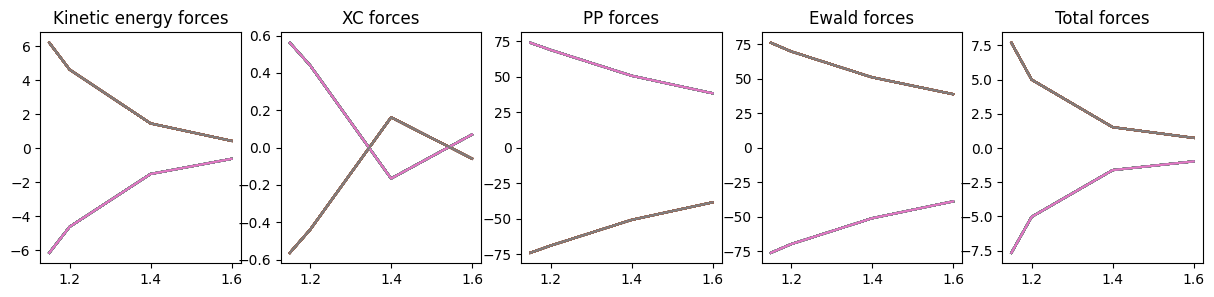

In [18]:
atom1_x_ke = [F_ngbrv_f_ke[0][0][0], F_ngbrv_f_ke[1][0][0], F_ngbrv_f_ke[2][0][0], F_ngbrv_f_ke[3][0][0]]
atom2_x_ke = [F_ngbrv_f_ke[0][1][0], F_ngbrv_f_ke[1][1][0], F_ngbrv_f_ke[2][1][0], F_ngbrv_f_ke[3][1][0]]
atom1_x_xc = [F_ngbrv_f_xc[0][0][0], F_ngbrv_f_xc[1][0][0], -F_ngbrv_f_xc[2][0][0], F_ngbrv_f_xc[3][0][0]]
atom2_x_xc = [F_ngbrv_f_xc[0][1][0], F_ngbrv_f_xc[1][1][0], -F_ngbrv_f_xc[2][1][0], F_ngbrv_f_xc[3][1][0]]
atom1_x_pp = [F_ngbrv_f_pp[0][0][0], F_ngbrv_f_pp[1][0][0], F_ngbrv_f_pp[2][0][0], F_ngbrv_f_pp[3][0][0]]
atom2_x_pp = [F_ngbrv_f_pp[0][1][0], F_ngbrv_f_pp[1][1][0], F_ngbrv_f_pp[2][1][0], F_ngbrv_f_pp[3][1][0]]
atom1_x_ew = [F_ngbrv_f_ew[0][0][0], F_ngbrv_f_ew[1][0][0], F_ngbrv_f_ew[2][0][0], F_ngbrv_f_ew[3][0][0]]
atom2_x_ew = [F_ngbrv_f_ew[0][1][0], F_ngbrv_f_ew[1][1][0], F_ngbrv_f_ew[2][1][0], F_ngbrv_f_ew[3][1][0]]


import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15,3))

for i in np.arange(len(rho[0][0])-10):
    axs[0].plot(alats,atom1_x_ke, label='KE')
    axs[0].plot(alats,atom2_x_ke, label='KE')
    axs[1].plot(alats,atom1_x_xc, label='XC')
    axs[1].plot(alats,atom2_x_xc, label='XC')
    axs[2].plot(alats,atom1_x_pp, label='PP')
    axs[2].plot(alats,atom2_x_pp, label='PP')
    axs[3].plot(alats,atom1_x_ew, label='EW')
    axs[3].plot(alats,atom2_x_ew, label='EW')
    axs[4].plot(alats,atom1_x_anl)
    axs[4].plot(alats,atom2_x_anl)

axs[0].set_title('Kinetic energy forces')
axs[1].set_title('XC forces')
axs[2].set_title('PP forces')
axs[3].set_title('Ewald forces')
axs[4].set_title('Total forces')
# plt.legend()

/tmp/ipykernel_57931/2521442392.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


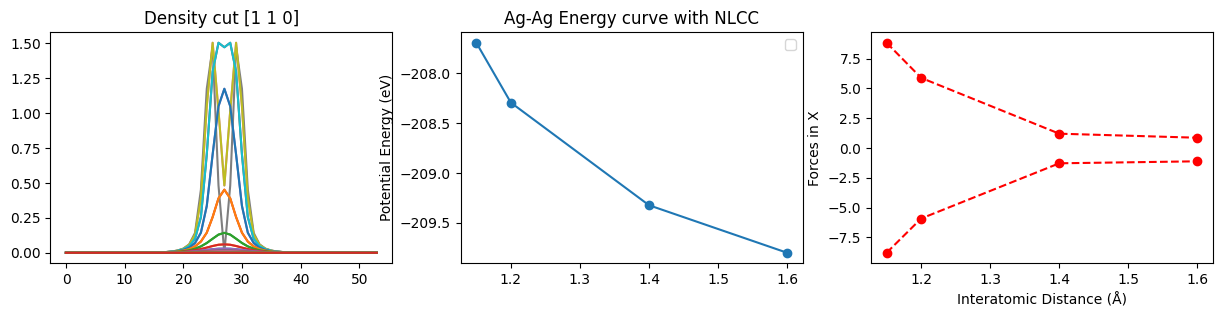

In [38]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,3))

for i in np.arange(len(rho[0][0])):
    axs[0].plot((rho)[28,i,:].ravel())

axs[1].scatter(alats[0:],  np.asarray(E_ngbrv_f[0:]))
axs[1].plot(alats[0:],  np.asarray(E_ngbrv_f[0:]))

axs[2].plot(alats[0:], np.asarray(atom1_x_anl[0:])-2*np.asarray(atom1_x_xc), '--', label='Analytical', marker='o', color='r')
axs[2].set_ylabel('Forces in X')
axs[2].set_xlabel('Distance')
axs[2].plot(alats[0:], np.asarray(atom2_x_anl[0:])-2*np.asarray(atom2_x_xc), '--',  marker='o', color='r')


plt.xlabel('Interatomic Distance (Å)')
axs[1].set_ylabel('Potential Energy (eV)')

axs[0].set_title('Density cut [1 1 0]')
axs[1].set_title('Ag-Ag Energy curve with NLCC')

axs[1].legend()
plt.show()